[Benjamin Chan](https://www.linkedin.com/in/benjamin-chan-chun-ho) - [Data Science Proof of Concept](https://github.com/BenjaminChanChunHo/Data-Science-Proof-of-Concept)

The theories are summarized from [Reference](#Reference) at the end. The data analysis and Python coding are done by me. The core program is in [Class Definition](#Class-Definition). Important terminologies are highlighted in the first mention.

# Introduction

A `Naive Bayes classifier` is a probabilistic model based on the `Bayes' theorem` with the assumption of `conditional independence` between the features. It is highly scalable since the conditional independence implies that each distribution can be independently estimated as one-dimensional distribution. It can handle mixed variable types separately. The computation grows linearly with the number of features. Despite strong assumption, they often outperform sophisticated classifiers.

Suppose the goal is to classify an observation into one of $K$ classes, where $K\geq 2$, i.e. there is a set of classes $C\in \{C_1,\dots,C_K\}$. Assume that there are $J$ features, i.e. $X=(X_1,\dots,X_J)'$. In other words, $X_j$ is a random variable and $X$ is a random vector. Note that $X=x$ means $(X_1=x_1,\dots,X_J=x_J)'$.

For illustration, the 10th most popular data called [abalone](https://archive.ics.uci.edu/ml/datasets/Abalone) in [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) is used. The original goal is to predict the age of abalone from physical measurements. To turn it into a classification problem, let's treat Sex as the target class with unique labels being F (female), M (male) and I (infant). In this data, there are $K=3$ classes and $J=8$ variables. 

The variables are highly correlated, as indicated by the correlation matrix [here](#EDA). Making conditional independence assumption in Naive Bayes classifier clearly simplifies the matter. In fact, I have once applied Bayesian Structural Equation Model (SEM) to this data to group highly correlated variables into latent variables and assess interrelationship among them. Please visit [this repository](https://github.com/BenjaminChanChunHo/Bayesian-Latent-Variable-Model-On-Abalone-Data) if interested.

On the other hand, the bell shape in histograms [here](#EDA) suggests that Gaussian (or normal) distribution can be a candidate for estimating conditional marginal densities mentioned [later](#Prob-Estimation). To be more rigorous, you should look at conditional distributions [here](#KDE-Plot). Kernel density estimation of continuous distribution is an alternative that is outside the scope of this study. For the time being, let's work for the implementation of Gaussian Naive Bayes classifier in [Class Definition](#Class-Definition).

# Data: Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

print(f'pandas=={pd.__version__}')
print(f'numpy=={np.__version__}')
print(f'seaborn=={sns.__version__}')

pandas==1.0.5
numpy==1.18.5
seaborn==0.11.0


For reproducibility, there is no need to download data yourself. The following code chunk would automatically download online and put it in a repository. Note that Rings (the number of rings) plus 1.5 gives the age in years. Sex is the target class and the rest are considered to be predictors. Data is split into training set (70%) and testing set (30%) randomly.

In [2]:
import os
from urllib.request import urlretrieve

Data_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
Data_Path = './Data/abalone.csv'

if not os.path.exists('./Data'):                        # See if the folder Data exists
    os.mkdir('./Data')                                  # If not, create it 
    
if not os.path.exists(Data_Path):                        # See if the data has been downloaded
    urlretrieve(Data_URL, Data_Path)                     # If not, download it
    
Col_Name = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_Weight', 'Shucked_Weight', 'Viscera_Weight', 'Shell_Weight', 'Rings']
Data = pd.read_csv(Data_Path, names = Col_Name)

Label = 'Sex'
Predictor_List = [Col for Col in Data.columns if Col != Label]
print(f'The label is {Label} while the predictors are \n\t{", ".join(Predictor_List)}.')

X = Data.loc[:, Predictor_List]                          # Predictors
y = Data[Label]                                          # Labels

from sklearn.model_selection import train_test_split     # Train-test split of data
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Full_Train = pd.concat([y_Train, X_Train], axis = 1)     # Full training data
Full_Test = pd.concat([y_Test, X_Test], axis = 1)        # Full testing data

Data.head()

The label is Sex while the predictors are 
	Length, Diameter, Height, Whole_Weight, Shucked_Weight, Viscera_Weight, Shell_Weight, Rings.


,Sex,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Concept of Bayes' Theorem

The Bayes' theorem states that
$$\mathbb{P}(A\mid B) = \frac{\mathbb{P}(B\mid A)\ \mathbb{P}(A)}{\mathbb{P}(B)}$$

where $A$ and $B$ are events. For notational convenience, $\mathbb{P}$ denotes the term probability for a discrete variable, but the term density for a continuous variable.

# Concept of Prior and Posterior Probability

Let $\pi_k = \mathbb{P}(\mathcal{C} = C_k)$ be the `prior probability` that a randomly chosen example comes from the class $C_k$. Let $f_k(x) = \mathbb{P}(X = x\mid \mathcal{C} = C_k)$ be the `conditional joint density (or probability)`. Note that $f_k(x)$ is sometimes called the `likelihood`. Let $f_{kj}(x_j) = \mathbb{P}(X_j=x_j\mid \mathcal{C} = C_k)$ be the `conditional marginal density (or probability)`. 

Let $p_k(x)=\mathbb{P}(\mathcal{C} = C_k\mid X=x)$ be the `posterior probability` that an observation $X = x$ belongs to the class $C_k$. Using the Bayes' theorem gives

$$\begin{align*}
p_k(x) & = \mathbb{P}(\mathcal{C} = C_k\mid X=x) \\[3pt]
& = \frac{\mathbb{P}(\mathcal{C} = C_k)\ \mathbb{P}(X=x\mid \mathcal{C} = C_k)}{\mathbb{P}(X=x)} \\[3pt]
& = \frac{\mathbb{P}(\mathcal{C} = C_k)\ \mathbb{P}(X=x\mid \mathcal{C} = C_k)}{\sum_{l=1}^K\mathbb{P}(\mathcal{C} = C_l)\ \mathbb{P}(X=x\mid \mathcal{C} = C_l)} \\[3pt]
& = \frac{\pi_kf_k(x)}{\sum_{l=1}^K\pi_lf_l(x)} \\[3pt]
& \propto \pi_kf_k(x)
\end{align*} $$

where the proportionality comes from the fact that $\mathbb{P}(X=x)$ is a constant that does not depend on $\mathcal{C}$ when the data $X=x$ is observed. Note that the `law of total probability` is used in $\mathbb{P}(X=x) = \sum_{l=1}^K\mathbb{P}(\mathcal{C} = C_l)\ \mathbb{P}(X=x\mid \mathcal{C} = C_l)$. Informally speaking, 
> Posterior probability is proportional to prior probability times likelihood.

# Concept of Conditional Independence

The chain rule of probability states that
$$\mathbb{P}(A \cap B) = \mathbb{P}(A)\ \mathbb{P}(B \mid A)$$

where $\cap$ stands for intersection and $B \mid A$ stands for $B$ given $A$. Using the chain rule repeatedly gives 

$$\begin{align*} 
f_k(x) & = \mathbb{P}(X_1=x_1,X_2=x_2,\dots,X_J=x_J\mid \mathcal{C} = C_k) \\
& = \mathbb{P}(x_1\mid C_k)\ \mathbb{P}(x_2 \mid x_1,C_k)\cdots \mathbb{P}(x_J\mid x_1,\dots, x_{J-1}, C_k).
\end{align*}$$

The Naive Bayes classifier assumes that the features are conditionally independent, i.e.

$$\mathbb{P}(X_j = x_j\mid X_1=x_1,\dots,X_{j-1}=x_{j-1}, \mathcal{C} = C_k) = \mathbb{P}(X_j = x_j\mid \mathcal{C} = C_k) = f_{kj}(x_j).$$

In other words, it simplifies the likelihood to be
$$f_k(x)=\prod_{j=1}^J f_{kj}(x_j).$$
> Variables are conditionally independent if and only if the conditional joint density (or probability) is the product of conditional marginal ones.

# Concept of Maximum a Posteriori Estimation

Under the `maximum a posteriori` (MAP) estimation, the Naive Bayes classifier generates the predicted class label $\hat{y}$ as 
$$\begin{align*} 
\hat{y} & = \mathop{\arg\max}_{k\in \{1,\dots,K\}} \pi_k \prod_{j=1}^J f_{kj}(x_j) \\
& = \mathop{\arg\max}_{k\in \{1,\dots,K\}} \mathbb{P}(\mathcal{C} = C_k)\prod_{j=1}^J \mathbb{P}(X_j=x_j\mid \mathcal{C} = C_k) 
\end{align*}$$

<a id = 'EDA'></a>
# Data: Exploratory Data Analysis

Correlation matrix is created from the training data:


,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Rings
Length,1.000,0.986,0.799,0.926,0.900,0.905,0.896,0.552
Diameter,0.986,1.000,0.805,0.926,0.895,0.901,0.904,0.570
Height,0.799,0.805,1.000,0.792,0.751,0.771,0.787,0.527
Whole_Weight,0.926,0.926,0.792,1.000,0.968,0.967,0.953,0.540
Shucked_Weight,0.900,0.895,0.751,0.968,1.000,0.933,0.877,0.416
Viscera_Weight,0.905,0.901,0.771,0.967,0.933,1.000,0.906,0.501
Shell_Weight,0.896,0.904,0.787,0.953,0.877,0.906,1.000,0.632
Rings,0.552,0.570,0.527,0.540,0.416,0.501,0.632,1.000


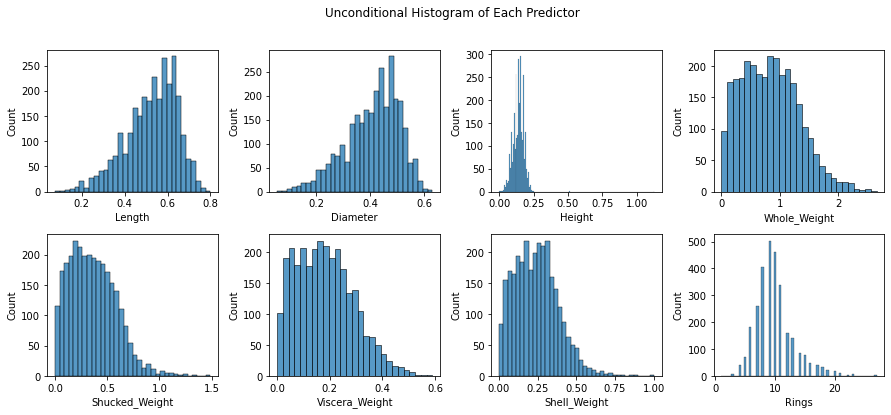

In [3]:
import matplotlib.pyplot as plt

print('Correlation matrix is created from the training data:')
display(X_Train.corr().round(3))

fig, axes = plt.subplots(2, 4, figsize = (15, 6))
fig.suptitle('Unconditional Histogram of Each Predictor')
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

for Col, ax in zip(Predictor_List, axes.flat):
    sns.histplot(data = Full_Train, x = Col, ax = ax)                      # Plot histograms

<a id = 'Prob-Estimation'></a>
# Concept of Probability and Density Estimation
The Naive Bayes classifier handles mixed distributions seamlessly. By conditional independence, $f_k(x)=\prod_{j=1}^J f_{kj}(x_j)$. Without loss of generality, let's consider one distribution at a time as if any $f_{kj}$ comes from that form. The results can always be combined by the product operation.

## Prior Probability

The prior probability is usually estimated by the proportion of class occurrence in the training data. Let $\mathcal{C}^{(i)}$ be the observed class of example $i\in\{1,\dots,N\}$, where $N$ is the number of examples. A prior probability is estimated by

$$\hat{\pi}_k = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(\mathcal{C}^{(i)} = C_k) \triangleq \frac{N_k}{N}$$

where $N_k=\sum_{i=1}^N \mathbb{1}(\mathcal{C}^{(i)} = C_k)$ is the number of examples in class $C_k$. The empirical prior probabilities of the abalone data can be found [here](#Fit).

## Continuous Distribution

If $X_j$ is continuous, the conditional marginal density $f_{kj}(x_j)$ can be estimated using any kernel or parametric method, depending on the probability distribution of a variable. There are no restrictions on the distribution form of $f_{kj}$ in the Naive Bayes classifier. One needs to check the empirical distribution before making any assumption about a variable. In fact, there are goodness-of-fit tests such as the Kolmogorov–Smirnov (KS) test.

For the time being, consider a common continuous distribution. Let $Y$ follow a Gaussian distribution with mean $\mu$ and variance $\sigma^2$, denoted by $Y\sim N(\mu,\sigma^2)$, where $\Omega =\{(\mu,\sigma^2): \mu\in \mathbb{R}, \sigma > 0\}$. Its probability density function (pdf) is 
$$f(y) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\bigg\{-\frac{(y-\mu)^2}{2\sigma^2}\bigg\}$$
where $y\in \mathbb{R}$ and $(\mu,\sigma^2) \in \Omega$. 

In the context of Naive Bayes classifier, let $\mu_{kj}$ and $\sigma^2_{kj}$ be the mean and variance of $X_j$ under $\mathcal{C} = C_k$. Assume that $X_j\mid C_k \sim N(\mu_{kj}, \sigma^2_{kj})$. Then
$$f_{kj}(x_j) = \frac{1}{\sqrt{2\pi\sigma^2_{kj}}} \exp\bigg\{-\frac{(x_j-\mu_{kj})^2}{2\sigma^2_{kj}}\bigg\}.$$

If the distribution of a continuous random variable is far from being Gaussian, the `kernel density estimate` can be utilized. Common smoothing algorithms use a Gaussian kernel. Its technical details are outside the scope of this study. However, you can find my empirical results [here](#KDE-Plot).

For the sake of completeness, it is important to mention the possibility of some other distributions, even though they are not applicable to the abalone data. Please refer to some details in [Appendix](#Appendix).

# Class Definition

In [4]:
class Gaussian_Naive_Bayes:
    '''
    Data and output are stored to trade memory for efficiency. 
        Here Data should be interpreted as the training data.
        Such implementation can be changed.
    
    For simplicity, only Gaussian distribution is considered.
    '''
    
    def __init__(self, Predictor_List, Label, Class_List):
        '''
        Predictor_List:
            the list of predictor(s) assumed to have Gaussian distribution(s) 
        Label: 
            the column name in Data that gives the class labels
        Class_List:
            the list of unique classes
        '''
        
        self.Predictor_List = Predictor_List
        self.Label = Label
        
        Class_Dict = dict()                                         # Initialize Class_Dict   
        Predictor_Dict = dict()                                     # Initialize Predictor_Dict
        
        for k, C_k in enumerate(Class_List, 1):
            Class_Dict[k] = C_k                                     # Key: Class index; Value: Class
            
        for j, X_j in enumerate(Predictor_List, 1):
            Predictor_Dict[j] = X_j                                 # Key: Predictor index; Value: Predictor
        
        self.Class_Dict = Class_Dict
        self.Predictor_Dict = Predictor_Dict
    
    def Calculate_Gauss_Density(self, x, Mean, SD):
        '''
        If X follows a Gaussian distribution with parameters Mean and SD^2, i.e. X ~ N(Mean, SD^2), 
            the output is its density of X = x.
        '''
        
        V = SD ** 2                                                 # Variance = SD^2
        Density = np.exp(-(x - Mean) ** 2 / (2 * V)) / (np.sqrt(2 * np.pi * V))

        return np.array(Density)

    def Calculate_Unconditional_Gauss(self, Var, x):
        '''
        Similar to the function Calculate_Gauss_Density. Mean and SD are estimated from Data.
        Var is the variable under investigation and x is value(s) of it.
        The output is its unconditional Gaussian density of X = x.
        '''
        
        Mean = np.mean(self.Data[Var])                              # Compute sample mean           
        SD = np.std(self.Data[Var], ddof = 1)                       # Compute sample standard deviation
        Density = self.Calculate_Gauss_Density(x, Mean, SD)

        return Density
    
    def Calculate_Conditional_Marginal_Mean_SD(self):
        '''
        mu_kj and sd_kj are the mean and standard deviation of X_j under class C_k.
        Each output is a dictionary with key being tuple (k, j). The value is either Mean or SD. 
        '''
        
        Cond_Marginal_Mean_Dict = dict()
        Cond_Marginal_SD_Dict = dict()
        
        for k, C_k in self.Class_Dict.items():                      # Loop over classes
            for j, X_j in self.Predictor_Dict.items():              # Loop over predictors
                Row_Ind = self.Data[self.Label] == C_k              # Row indicators of class k
                Data_kj = self.Data.loc[Row_Ind, X_j].copy()        # Select relevant data for mean & sd
                
                # Store mean & sd of class k & predictor j in two dictionaries
                Cond_Marginal_Mean_Dict[(k, j)] = np.mean(Data_kj)
                Cond_Marginal_SD_Dict[(k, j)] = np.std(Data_kj, ddof = 1)
                
        self.Cond_Marginal_Mean_Dict = Cond_Marginal_Mean_Dict
        self.Cond_Marginal_SD_Dict = Cond_Marginal_SD_Dict
    
    def Calculate_Conditional_Marginal_Gauss(self, Data):
        '''
        Use the function Calculate_Conditional_Marginal_Mean_SD to obtain mu_kj and sd_kj,
            mean and standard deviation of X_j under class C_k.
        The output is a dictionary with key being tuple (k, j) and value being Gaussian densities of 
            X_j = x_j and C_k.
        '''
        
        Density = dict()
        
        for k, C_k in self.Class_Dict.items(): 
            for j, X_j in self.Predictor_Dict.items():
                Mean_kj = self.Cond_Marginal_Mean_Dict[(k, j)] 
                SD_kj = self.Cond_Marginal_SD_Dict[(k, j)]
                
                # Store Gaussian densities of X_j & C_k in a dictionary
                Density_kj = self.Calculate_Gauss_Density(Data.loc[:, X_j], Mean_kj, SD_kj)
                Density[(k, j)] = Density_kj
                
        return Density
    
    def Calculate_Prior_Probability(self, Data):
        '''
        Estimate the prior probabilities by class proportions.
        The output is a dictionary with key being class label and value being its prior probability.
        '''
        
        Prior_Probability = dict()
                
        for k, C_k in self.Class_Dict.items():
            Prior_Probability[C_k] = (Data.loc[:, self.Label] == C_k).mean()
            
        assert sum(Prior_Probability.values()) == 1, 'The sum of prior probabilities should be 1!'
        
        return Prior_Probability
    
    def Fit(self, Data):
        '''
        Data is the training data used to estimate Gaussian densities.
        
        Wrapper function to 
            1) call Calculate_Conditional_Marginal_Mean_SD;
            2) fit Data into Calculate_Prior_Probability;
        '''
        
        self.Data = Data
        self.Calculate_Conditional_Marginal_Mean_SD()               # Objective 1
        
        Prior_Probability = self.Calculate_Prior_Probability(Data)  # Objective 2
        self.Prior_Probability = Prior_Probability
        
    def Plot_Fit(self, axes):
        '''
        Plot Gaussian densities of each predictor by class into axes.
        '''
        
        for j, ax in enumerate(axes.flat, 1):
            Col = self.Predictor_Dict[j]                            # Current column name
            Min, Max = self.Data[Col].min(), self.Data[Col].max()   # Minimum & maximum in x-axis
            x = np.linspace(Min, Max, 1000)                         # x values in x-axis
            ax.set_xlabel(Col); ax.set_ylabel('Density')            # Set labels of x-axis & y-axis
            
            for k, C_k in self.Class_Dict.items(): 
                Mean_kj = self.Cond_Marginal_Mean_Dict[(k, j)]      # Extract mean of class k, variable j
                SD_kj = self.Cond_Marginal_SD_Dict[(k, j)]          # Extract sd of class k, variable j
                
                Density_kj = self.Calculate_Gauss_Density(x, Mean_kj, SD_kj)
                ax.plot(x, Density_kj, label = C_k)                 # Plot conditional marginal Gaussian densities
            
            ax.legend(title = self.Label)                           # Add legend
            
    def Predict(self, Data):
        '''
        Compute posterior probabilities and make prediction.
        '''
        
        Density = self.Calculate_Conditional_Marginal_Gauss(Data)
        
        Class_List = list(self.Class_Dict.values())
        Prob = pd.DataFrame(columns = Class_List)
                
        for k, C_k in self.Class_Dict.items():
            Prior_k = self.Prior_Probability[C_k]
            Density_k = [val for key, val in Density.items() if key[0] == k]
            Likelihood_k = np.prod(Density_k, axis = 0)             # Array of likelihood of class k per record
            Prob[C_k] = Likelihood_k * Prior_k
        
        Prob = Prob.div(Prob.sum(axis = 1), axis = 0)               # Normalized by row-sums to give probabilities
        Predict = np.array(Prob.idxmax(axis = 1))
        
        return Prob, Predict
    
    def Fit_Predict(self, Data):
        '''
        Fit Data and then compute posterior probabilities. Finally make prediction.
        '''
        
        self.Fit(Data)
        Prob, Predict = self.Predict(Data)
        
        return Prob, Predict

<a id = 'Fit'></a>
# Data: Fitting Gaussian Naive Bayes Model

Inside the object, Class_Dict is a dictionary whose key is $k$ and value is $C_k$ for $k=1,2,3$. On the other hand, Predictor_Dict is a dictionary whose key is $j$ and value is $X_j$ for $j=1,\dots,8$. Based on the training data, the prior probability of male is estimated to be 0.3705. It is the highest among others, meaning that male abalones are most prevailing.

In [5]:
Class_List = ['F', 'M', 'I']
Abalone_Gauss = Gaussian_Naive_Bayes(Predictor_List, Label, Class_List)
Abalone_Gauss.Fit(Full_Train)                                       # Fit using training data 
Abalone_Prob, Abalone_Predict = Abalone_Gauss.Predict(Full_Test)    # Predict using testing data

Abalone_Prior = {k: round(v, 4) for k, v in Abalone_Gauss.Prior_Probability.items()}

print(f'Abalone class dictionary: {Abalone_Gauss.Class_Dict}')
print(f'\nAbalone predictor dictionary: {Abalone_Gauss.Predictor_Dict}')
print(f'\nAbalone prior probabilities: {Abalone_Prior}')

Abalone class dictionary: {1: 'F', 2: 'M', 3: 'I'}

Abalone predictor dictionary: {1: 'Length', 2: 'Diameter', 3: 'Height', 4: 'Whole_Weight', 5: 'Shucked_Weight', 6: 'Viscera_Weight', 7: 'Shell_Weight', 8: 'Rings'}

Abalone prior probabilities: {'F': 0.3151, 'M': 0.3705, 'I': 0.3144}


# Data: Sanity Check

In [6]:
from scipy.stats import norm                                       # Using scipy package for Gaussian random variable

x = np.linspace(-3.5, 3.5, 1000)
Mean = 0; SD = 1                                                   # Set to be standard Gaussian: N(0,1)
Def_Density = Abalone_Gauss.Calculate_Gauss_Density(x, Mean, SD)   # Gaussian densities from self-defined function
SP_Density = norm.pdf(x, Mean, SD)                                 # Gaussian densities from scipy method

if np.allclose(Def_Density, SP_Density):                           # True if arrays are element-wise equal within a tolerance
    print('Using self-defined function gives the same Gaussian densities as using scipy.stats.norm.')

Using self-defined function gives the same Gaussian densities as using scipy.stats.norm.


<a id = 'KDE-Plot'></a>
# Data: Density Estimation

The Gaussian density plots resemble the corresponding kernel density estimate plots, which suggests that they are comparable for density estimation in this application. Since kernel methods are outside the scope of my study, the Naive Bayes classifier using kernel density estimates is not demonstrated.

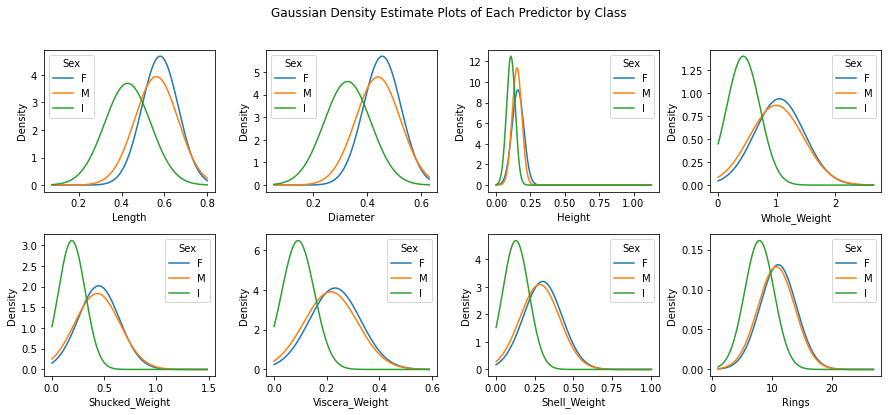

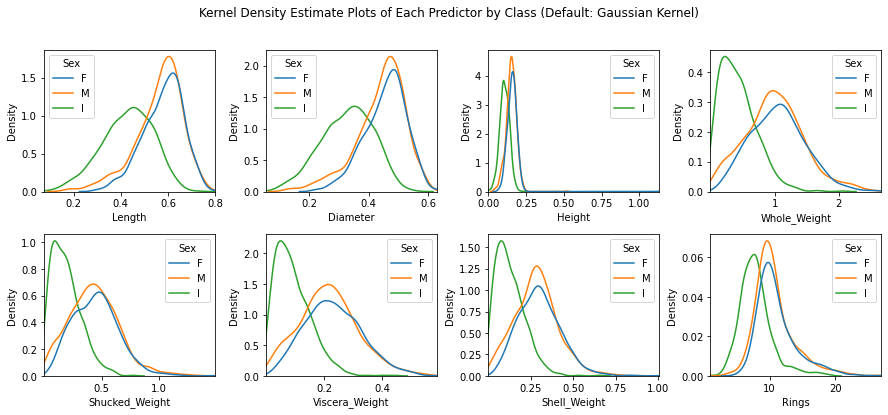

In [7]:
fig, axes = plt.subplots(2, 4, figsize = (15, 6))
fig.suptitle('Gaussian Density Estimate Plots of Each Predictor by Class')
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

Abalone_Gauss.Plot_Fit(axes)

fig, axes = plt.subplots(2, 4, figsize = (15, 6))
fig.suptitle('Kernel Density Estimate Plots of Each Predictor by Class (Default: Gaussian Kernel)')
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

for Col, ax in zip(Predictor_List, axes.flat):
    ax.set_xlim(Full_Train[Col].min(), Full_Train[Col].max())     # Minimum & maximum in x-axis are variable's ones
    sns.kdeplot(data = Full_Train, x = Col, hue = Label, hue_order = ['F', 'M', 'I'], ax = ax)

# Data: Evaluation on Testing Data

Note that there are very small discrepancies between sklearn and self-defined probability estimates, as shown by the side-by-side comparison of the first few records and the mean absolute deviation by class. However, all the predicted classes are the same in this case. 

The classification accuracy is 52.9%, which is rather low, mainly because male and female abalones are very similar in every variable, as shown above. If they are combined to form one class called non-infant, the task can be simpler, as shown [here](#Experiment). 

In [8]:
from sklearn.naive_bayes import GaussianNB                          # Using sklearn to fit Gaussian Naive Bayes
from utils import display_side_by_side                              # Self-defined: display tables side by side

SK_GaussNB = GaussianNB()                                           # Initialize
SK_GaussNB.fit(X_Train, y_Train)                                    # Fit data
SK_GaussNB_Prob = SK_GaussNB.predict_proba(X_Test)                  # Return probability estimates (testing data)
SK_GaussNB_Prob = pd.DataFrame(SK_GaussNB_Prob, columns = SK_GaussNB.classes_)
SK_GaussNB_Prob = SK_GaussNB_Prob.loc[:, Class_List]                # Re-order columns
SK_GaussNB_Predict = SK_GaussNB.predict(X_Test)                     # Return prediction

display_side_by_side([SK_GaussNB_Prob.head(), Abalone_Prob.head()], captions = ['sklearn', 'self-defined'])

print('Mean absolute deviation of probability estimates by class:', 
      np.absolute(SK_GaussNB_Prob - Abalone_Prob).mean().round(5).to_dict())
print('Proportion of the same predicted classes:', (Abalone_Predict == SK_GaussNB_Predict).mean())

Abalone_Crosstab = pd.crosstab(Abalone_Predict, y_Test, rownames = ['Predicted'], colnames = ['Actual'])
Abalone_Crosstab = Abalone_Crosstab.loc[Class_List, Class_List]
display(Abalone_Crosstab)
print(f'The prediction accuracy in testing data is {(Abalone_Predict == y_Test).mean():.1%}.')

,F,M,I
0,0.526702,0.473261,0.000037
1,0.026619,0.066746,0.906634
2,0.643399,0.356601,0.000000
3,0.000000,0.000000,1.000000
4,0.681146,0.318854,0.000000
,F,M,I
0,0.526606,0.473356,0.000038
1,0.026668,0.066803,0.906529
2,0.643232,0.356768,0.000000
3,0.000000,0.000000,1.000000


Mean absolute deviation of probability estimates by class: {'F': 8e-05, 'M': 0.0001, 'I': 4e-05}
Proportion of the same predicted classes: 1.0


Actual,F,M,I
Predicted,,,
F,235,236,27
M,70,88,56
I,81,121,340


The prediction accuracy in testing data is 52.9%.


<a id = 'Experiment'></a>
# Data: Experiment on Combining Classes

By combining M and F into Non-I (non-infant) and keeping I (infant), it reduces to binary classification. Since the difference between infant and non-infant abalones is obvious, the accuracy increases from 52.9% to 77.8%.

In [9]:
Train_New = Full_Train.copy()                                                       # Create a copy of training data 
Test_New = Full_Test.copy()                                                         # Create a copy of testing data 

Train_New['Sex'] = Train_New['Sex'].map({'M': 'Non-I', 'F': 'Non-I', 'I': 'I'})     # Change M & F to Non-I
Test_New['Sex'] = Test_New['Sex'].map({'M': 'Non-I', 'F': 'Non-I', 'I': 'I'})

Abalone_New = Gaussian_Naive_Bayes(Predictor_List, Label, ['I', 'Non-I'])
Abalone_New.Fit(Train_New)                                                          # Fit new training data 
Prob_New, Predict_New = Abalone_New.Predict(Test_New)                               # Predict using new testing data

print('New prior probabilities:', {k: round(v, 4) for k, v in Abalone_New.Prior_Probability.items()})

Crosstab_New = pd.crosstab(Predict_New, Test_New['Sex'], rownames = ['Predicted'], colnames = ['Actual'])
display(Crosstab_New)

Target_New = Test_New['Sex']
print(f'The prediction accuracy in new testing data is {(Predict_New == Target_New).mean():.1%}.')

New prior probabilities: {'I': 0.3144, 'Non-I': 0.6856}


Actual,I,Non-I
Predicted,,
I,340,195
Non-I,83,636


The prediction accuracy in new testing data is 77.8%.


# Appendix

## Bernoulli Distribution
In the case of bag of words in document classification, suppose that there is a Bernoulli feature $X_j$ associated with each of $J$ unique words in the vocabulary. The term Bernoulli means that $x_j=1$ if that word appears in the document, and $x_j=0$ otherwise. In other words, $x=(x_1,\dots,x_J)'$ where $x_j\in\{0,1\}$. In short, $X_j$ represents the presence or absence of a word.

Statistically, a conditional marginal probability is given by

$$\begin{align*}
f_{kj}(x_j) & = \mathbb{P}(X_j = x_j\mid \mathcal{C} = C_k) \\
& = p_{kj}^{x_j} (1-p_{kj})^{1-x_j}
\end{align*}$$

where $p_{kj}=\mathbb{P}(X_j=1\mid \mathcal{C} = C_k)$. In general, $p_{kj}$ is estimated by the sample proportion of $x_j=1$ in the training data.

## Multinomial Distribution
In the case of bag of words, suppose that there are $J$ unique words in the vocabulary. Each document is thought to be drawn from a multinomial distribution of words. Let $x_j$ be the number of occurrences of word $j$, hence $\sum_{j=1}^J x_j$ is the length of document.

A multinomial distribution has the probability mass function (pmf)
$$\mathbb{P}(X_1=x_1,\dots,X_J=x_J)=\frac{(\sum_{j=1}^J x_j)!}{\prod_{j=1}^J x_j!}\prod_{j=1}^J p_j^{x_j}.$$

It corresponds to obtaining $x_1,\dots,x_J$ of the word each with probability $p_1,\dots,p_J$ of occurrence respectively, where $0<p_j<1$ for $j=1,\dots,J$ and $\sum_{j=1}^J p_j=1$. 

In the context of Naive Bayes classifier, assume that the length of document is independent of class. Let $p_{kj}$ be the probability of occurrence of word $j$ in class $C_k$. Then
$$f_k(x) = \frac{(\sum_{j=1}^J x_j)!}{\prod_{j=1}^J x_j!}\prod_{j=1}^J p_{kj}^{x_j}.$$

## Categorical Distribution
Assume that a categorical variable $X^c$ has $J$ categories that are encoded into $1,\dots,J$. By dummy encoding, it leads to a random vector $X=(X_1,\dots,X_J)'$ where $X_j=\mathbb{1}(X^c=j)$ for $j=1,\dots,J$. It is also known as one-hot encoding, since only one of the $J$ variables has the value one. 

In fact, a categorical distribution is a special case of multinomial distribution when $\sum_{j=1}^J x_j=1$. Thus
$$f_k(x) = \prod_{j=1}^J p_{kj}^{x_j}$$
where $p_{kj} = \mathbb{P}(X^c=j\mid \mathcal{C} = C_k)=\mathbb{P}(X_j=1\mid \mathcal{C} = C_k)$.

<a id = 'Experiment'></a>
## Data: Unconditional Plot

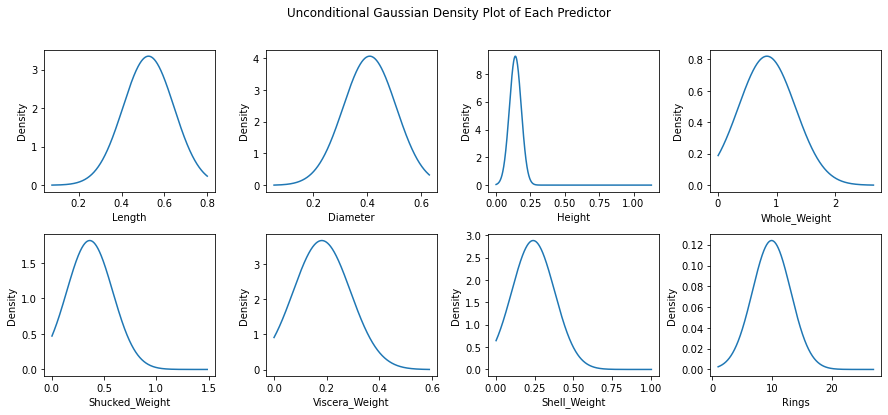

In [10]:
fig, axes = plt.subplots(2, 4, figsize = (15, 6))
fig.suptitle('Unconditional Gaussian Density Plot of Each Predictor')
fig.subplots_adjust(wspace = 0.3, hspace = 0.3)

for Col, ax in zip(Predictor_List, axes.flat):
    Min, Max = Full_Train[Col].min(), Full_Train[Col].max()
    x = np.linspace(Min, Max, 1000) 
    Uncond_Gauss_Density = Abalone_Gauss.Calculate_Unconditional_Gauss(Col, x)
    ax.set_xlabel(Col); ax.set_ylabel('Density')
    ax.plot(x, Uncond_Gauss_Density)                                       # Plot densities

# Reference
1. [Wikipedia: Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
2. [scipy: normal random variable](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)
3. [sklearn: Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
4. [sklearn: Kernel Density Estimation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html)
5. [seaborn: kernel density estimate](https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot)
6. [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/) by Hastie, Tibshirani and Friedman in 2001
7. [Naive (Bayes) at Forty: The Independence Assumption in Information Retrieval](https://link.springer.com/chapter/10.1007/BFb0026666) by Lewis in 1998
8. [A Comparison of Event Models for Naive Bayes Text Classification](https://www.semanticscholar.org/paper/A-comparison-of-event-models-for-naive-bayes-text-McCallum-Nigam/04ce064505b1635583fa0d9cc07cac7e9ea993cc) by McCallum and Nigam in 1998
9. [Machine Learning: A Probabilistic Perspective](https://dl.acm.org/doi/book/10.5555/2380985) by Murphy in 2012